In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.ensemble import RandomForestRegressor

In [6]:
# Load and preprocess the dataset
data = pd.read_csv("covid_19_clean_complete.csv")

In [7]:
# Filter for a specific country (e.g., "India")
country_name = "India"
country_data = data[data["Country/Region"] == country_name]

In [8]:
# Aggregate data by date
country_data["Date"] = pd.to_datetime(country_data["Date"])
country_data = country_data.groupby("Date").sum().reset_index()

<ipython-input-8-f0bd0bc90c4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Date"] = pd.to_datetime(country_data["Date"])


In [9]:
# Add active cases column
country_data["Active"] = country_data["Confirmed"] - country_data["Recovered"] - country_data["Deaths"]

In [10]:
# SIR Model Functions
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [11]:
# Initial Parameters
population = 1000000  # Approximate population (replace with actual if known)
I0 = country_data["Active"].iloc[0]
R0 = country_data["Recovered"].iloc[0]
S0 = population - I0 - R0
beta, gamma = 0.4, 0.1  # Initial guesses for SIR model
y0 = [S0 / population, I0 / population, R0 / population]

In [12]:
# Time points
t = np.linspace(0, len(country_data) - 1, len(country_data))

In [13]:
# Solve SIR model
solution = odeint(sir_model, y0, t, args=(beta, gamma))
solution = np.array(solution) * population

In [14]:
# Prepare ML Model
features = ["Confirmed", "Recovered", "Deaths"]
X = country_data[features].iloc[:-1]
y = country_data["Active"].iloc[1:]

In [15]:
# Train Random Forest for better parameter estimation
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

In [16]:
# ML-based Predictions
ml_predictions = rf.predict(X)

In [17]:
# Visualization
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

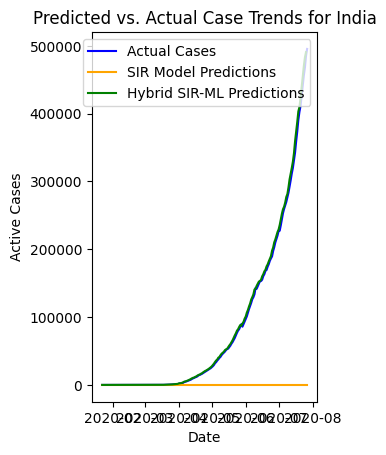

In [18]:
# Graph 1: Predicted vs. Actual Case Trends
plt.subplot(1, 2, 1)
plt.plot(country_data["Date"], country_data["Active"], label="Actual Cases", color="blue")
plt.plot(country_data["Date"], solution[:, 1], label="SIR Model Predictions", color="orange")
plt.plot(country_data["Date"][:-1], ml_predictions, label="Hybrid SIR-ML Predictions", color="green")
plt.title(f"Predicted vs. Actual Case Trends for {country_name}")
plt.xlabel("Date")
plt.ylabel("Active Cases")
plt.legend()

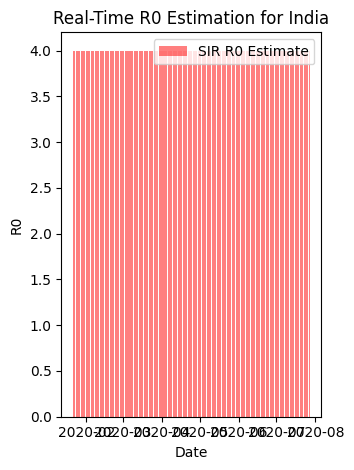

In [19]:
# Graph 2: Real-Time R0 Estimation
R0_sir = beta / gamma
plt.subplot(1, 2, 2)
plt.bar(country_data["Date"], [R0_sir] * len(country_data), label="SIR R0 Estimate", color="red", alpha=0.5)
plt.title(f"Real-Time R0 Estimation for {country_name}")
plt.xlabel("Date")
plt.ylabel("R0")
plt.legend()

plt.tight_layout()
plt.show()